Preprocessing data...
Training XGBoost model with hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.864

Test Accuracy: 0.863

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     12271
           1       0.65      0.35      0.45      2382

    accuracy                           0.86     14653
   macro avg       0.76      0.66      0.69     14653
weighted avg       0.85      0.86      0.85     14653



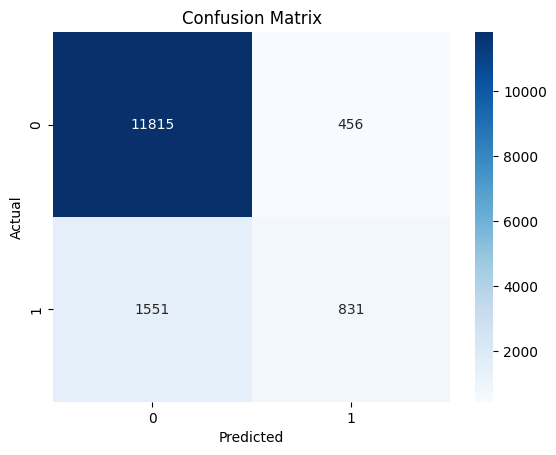


Analyzing feature importances...


<Figure size 1000x1000 with 0 Axes>

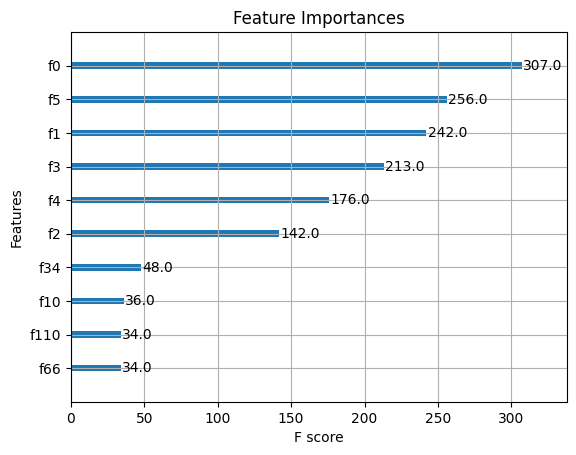

In [2]:
# Install necessary libraries
# !pip install xgboost numpy pandas matplotlib seaborn scikit-learn ucimlrepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance
from ucimlrepo import fetch_ucirepo

class AdultXGBoostAnalysis:
    def __init__(self):
        # Load data
        adult = fetch_ucirepo(id=2)  # Fetch dataset from UCI repo
        self.X = adult.data.features
        self.y = (adult.data.targets == '>50K').astype(int)  # Convert target to binary (0, 1)
        self.X_prepared = None
        self.model = None

    def preprocess_data(self):
        """Preprocesses data using pipelines for better organization."""
        # Define categorical and numerical features
        categorical_features = self.X.select_dtypes(include=['object']).columns.tolist()
        numerical_features = self.X.select_dtypes(exclude=['object']).columns.tolist()

        # Create preprocessing pipelines
        categorical_pipeline = Pipeline([
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
        numerical_pipeline = Pipeline([
            ('scaler', StandardScaler())
        ])

        # Combine pipelines using ColumnTransformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_pipeline, numerical_features),
                ('cat', categorical_pipeline, categorical_features)
            ])

        # Fit and transform the data
        self.X_prepared = preprocessor.fit_transform(self.X)

        return self.X_prepared, self.y

    def train_model(self):
        """Trains the XGBoost model with cross-validation for hyperparameter tuning."""
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.X_prepared, self.y, test_size=0.3, random_state=42)

        # Parameter grid for GridSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }

        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss', random_state=42),
                                   param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Print best parameters and accuracy
        print(f"\nBest Parameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.3f}")

        # Train the best model on the entire training set
        self.model = grid_search.best_estimator_
        self.model.fit(X_train, y_train)

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Evaluate performance
        acc = accuracy_score(y_test, y_pred)
        print(f"\nTest Accuracy: {acc:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return y_test, y_pred

    def feature_importance(self):
        """Analyzes feature importance."""
        # Plot feature importance
        plt.figure(figsize=(10, 10))
        plot_importance(self.model, max_num_features=10)
        plt.title('Feature Importances')
        plt.show()

def main():
    # Initialize analysis
    analysis = AdultXGBoostAnalysis()

    # Preprocess data
    print("Preprocessing data...")
    analysis.preprocess_data()

    # Train and evaluate the model
    print("Training XGBoost model with hyperparameter tuning...")
    y_test, y_pred = analysis.train_model()

    # Analyze feature importance
    print("\nAnalyzing feature importances...")
    analysis.feature_importance()

# Correct `__name__` guard
if __name__ == "__main__":
    main()
